In [93]:
import pandas as pd
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import sklearn.cluster
import sklearn.preprocessing
import nltk
import sklearn.ensemble
import sklearn.decomposition
import sklearn.metrics
import sklearn.dummy

In [2]:
# import the csv
dirty_mathematicians = pd.read_csv('data/math_data.csv', delimiter=',', na_values=["Ph.D."])

def year_translator(x):
    if type(x) == type(""):
        try:
            return int(x)
        except ValueError:
            return 0
    return x

dirty_mathematicians['numericYear'] = dirty_mathematicians.thesisYear.map(year_translator)

# get mathematician data
mathematicians = dirty_mathematicians[(dirty_mathematicians.numericYear != 0) 
                                      & (dirty_mathematicians.numericYear.notnull())
                                     & (dirty_mathematicians.numericYear < 10000)
                                     & (dirty_mathematicians.numericYear > 1000)
                                     & (dirty_mathematicians.thesisYear.notnull())
                                     & (dirty_mathematicians.thesisUniversity.notnull())
                                     & (dirty_mathematicians.thesis.notnull())]

In [3]:
# read in the csv data
#mathematicians = pd.read_csv('data/math_data.csv', delimiter=',')#, parse_dates='thesisYear')
#mathematicians = mathematicians[mathematicians.thesisYear.notnull()]

# take only those rows with a numeric mathId (the scraping went bad at some points)
#mathematicians = mathematicians[mathematicians.mathId.apply(lambda x: x.isnumeric())].set_index('mathId')

In [4]:
# add a row for numeric year
#years = mathematicians.thesisYear.apply(pd.to_numeric, errors='coerce')
#mathematicians = mathematicians[years.notnull()]
# some of the years were doubled up, eg 19771984. Fix in those cases:
#for idx in years[years > 10000].index:
#    years[idx] = float(int(years[idx]/10000))
# add a column to the dataframe with numeric years
#mathematicians['numericYear'] = years


# filter out some obvious bad ones, this might be throwing out a bunch of my data...
#mathematicians = mathematicians[(mathematicians.numericYear.isnull() == False)
#                               & (mathematicians.thesisYear > 1000)
#                               & (mathematicians.thesis.notnull()) 
#                                & (mathematicians.thesisUniversity.notnull())
#                               & (mathematicians.thesisCountry.notnull())]

In [5]:
# interesting idea: try to predict subject area from university and year and maybe advisor too.

# Counting most common universities and countries

In [6]:
encoder = sklearn.preprocessing.LabelEncoder()

In [7]:
encoder.fit_transform(mathematicians.thesisUniversity)

array([ 748,  748,  748, ...,  569, 1498, 1375])

In [8]:
encoder.classes_

array(['(Candidate of Sciences) Novosibirsk State University',
       '(Candidate of Sciences) Sobolev Institute of Mathematics Novosibirsk',
       "(Doctorat d'Etat) Université Paris Diderot - Paris 7", ...,
       'ès sciences techniques École Polytechnique Fédérale de Lausanne',
       'ès. sc. École Polytechnique Fédérale de Lausanne',
       'İstanbul Teknik Üniversitesi'], dtype=object)

In [9]:
mcUni1000 = list(mathematicians.thesisUniversity.value_counts().head(1000).index)

In [10]:
x = mathematicians[mathematicians.thesisUniversity.isin(mcUni1000)]

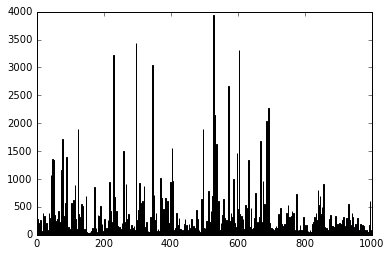

In [11]:
#plt.scatter(x.numericYear, encoder.fit_transform(x.thesisUniversity), c='blue')
_x = encoder.fit_transform(x.thesisUniversity)
plt.hist(_x, bins=500);

# Thesis title analysis

In [12]:
textblock = '\n'.join([line for line in mathematicians.thesis])
stopwords = nltk.corpus.stopwords.words('german') + \
            nltk.corpus.stopwords.words('english') + \
            nltk.corpus.stopwords.words('french') + \
            [';',',','.',':','(',')','de','la','rer','nat']
words = [word.lower() for word in nltk.word_tokenize(textblock) if word.lower() not in stopwords]
textobj = nltk.Text(words)

In [13]:
distobj=nltk.FreqDist(words)

In [14]:
finder = nltk.collocations.BigramCollocationFinder.from_words(textobj)
bigram_measures = nltk.collocations.BigramAssocMeasures()

In [15]:
bigrams = finder.nbest(bigram_measures.raw_freq, 50)


In [17]:
# run through the rows and see if these 2grams are in the thesis, if so plot the year.
def containsBiGram(aString, ngrams=bigrams):
    for ngram in ngrams:
        if ngram[0] in aString.lower() and ngram[1] in aString.lower():
            return True
    return False

def containsSpecificBiGram(aString, ngram):
    return ngram[0] in aString.lower() and ngram[1] in aString.lower()

def getFirstBiGram(aString, bigrams):
    for bigram in bigrams:
        if containsSpecificBiGram(aString, bigram):
            return bigram[0] + ' ' + bigram[1]
    return ""

In [20]:
bigram_encoder = sklearn.preprocessing.LabelEncoder()
bigram_encoder.fit_transform([x[0]+' '+x[1] for x in bigrams])

array([ 9, 35,  3, 49, 47, 16, 12,  2, 32, 29, 41, 31, 21, 17, 38, 15, 46,
       23, 34, 22, 19, 28, 33,  5, 24, 27, 45, 26, 18, 44,  1, 13, 11, 10,
       14, 48,  0,  6, 37, 30, 39, 43,  7, 20, 25, 36,  4, 42, 40,  8])

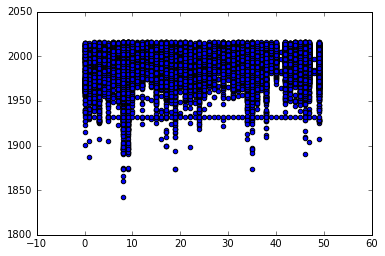

In [22]:
i=0
for bigram in bigrams:
    #print(ngram)
    s = mathematicians[mathematicians.thesis.map(lambda x: containsSpecificBiGram(x, bigram))].numericYear
    plt.scatter(np.array([bigram_encoder.transform(' '.join(bigram)) for x in s]), s, c='blue')
    i += 1

In [ ]:
bigram_encoder.inverse_transformrcodercoder.inverse

### Do some one-hot encoding
here we add some columns for the presence of a bigrams and university studied at

In [23]:
# add one hot encoding for the thesis title bigrams
bigramed_mathematicians = mathematicians[mathematicians.thesis.map(lambda x: containsBiGram(x, bigrams))]
for bigram in bigrams:
    _bi = ' '.join(bigram)
    bigramed_mathematicians[_bi] = np.where(bigramed_mathematicians.thesis.map(lambda x: containsSpecificBiGram(x, bigram)),1,0)

/Users/sebastianmueller/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [24]:
# add the one hot encoding for the thesis University
for uni in mcUni1000:
    bigramed_mathematicians[uni] = np.where(bigramed_mathematicians.thesisUniversity==uni, 1, 0)

/Users/sebastianmueller/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [25]:
# add labeled bigrams
bigramed_mathematicians['encoded_bigram'] = bigram_encoder.transform(bigramed_mathematicians.thesis.map(lambda x: getFirstBiGram(x, bigrams)))

/Users/sebastianmueller/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


### Prediction
lets try to predict the subject area (ie the bigram) just based on the university that you went to.


In [68]:
classifier = sklearn.ensemble.RandomForestClassifier()

In [69]:
X = bigramed_mathematicians[mcUni1000]
y = bigramed_mathematicians.encoded_bigram

In [70]:
classifier.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [71]:
predictions = classifier.predict(X)

In [72]:
sklearn.metrics.accuracy_score(predictions, y)

0.20540362799364278

In [73]:
zipped_results = list(zip(predictions, y))

### here is how we did:

In [33]:
# number correct
sum([1 for x in zipped_results if x[0] == x[1]])

3749

In [34]:
# number incorrect
sum([1 for x in zipped_results if x[0] != x[1]])

14498

### Not so great!
Things to try
    1. use pca to bring the dimension down and graph it and cluster it
    2. include the advisor
    3. include the year
    4. try random prediction to see how we did

In [35]:
# the whiten scales the dimensions the similar scales
pca = sklearn.decomposition.PCA(whiten=True)

In [36]:
trans_cols = pca.fit_transform(X)

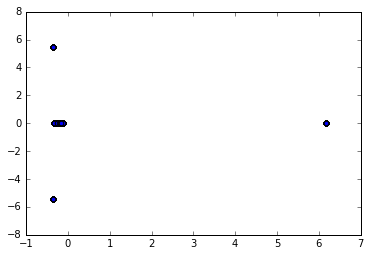

In [37]:
# the pca plot
plt.scatter(trans_cols[:,0], trans_cols[:,1])

In [38]:
no_unis = []
for i in range(len(X)):
    if X.iloc[i].sum() == 0:
        no_unis.append(i)

In [39]:
# bad data set:
len(no_unis)

728

In [46]:
pca.explained_variance_ratio_

array([  2.62511263e-02,   1.75672088e-02,   1.73339401e-02,
         1.67688989e-02,   1.63552185e-02,   1.50986141e-02,
         1.47963612e-02,   1.40469275e-02,   1.31180963e-02,
         1.19208671e-02,   1.18560697e-02,   1.17597917e-02,
         1.14164227e-02,   1.03468164e-02,   1.00870014e-02,
         1.00288762e-02,   9.98919718e-03,   9.94995653e-03,
         9.85077937e-03,   9.40061803e-03,   8.79839355e-03,
         8.39821073e-03,   7.85828194e-03,   7.29096576e-03,
         7.23000832e-03,   7.08242965e-03,   6.95259756e-03,
         6.74194704e-03,   6.58461808e-03,   6.52317000e-03,
         6.45577818e-03,   6.37241889e-03,   6.34397323e-03,
         6.31500971e-03,   6.19375540e-03,   5.99721603e-03,
         5.65247033e-03,   5.51128120e-03,   5.47794627e-03,
         5.38330389e-03,   5.23577147e-03,   5.08691323e-03,
         4.99379069e-03,   4.79202142e-03,   4.62963115e-03,
         4.53532516e-03,   4.48896489e-03,   4.36309762e-03,
         4.31723183e-03,

In [49]:
len(trans_cols)

18247

### Try adding the year

In [74]:
classifier = sklearn.ensemble.RandomForestClassifier()
X = bigramed_mathematicians[mcUni1000 + ['numericYear']]
y = bigramed_mathematicians.encoded_bigram
classifier.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [75]:
predictions = classifier.predict(X)
zipped_results = list(zip(predictions, y))
# number correct
print(sum([1 for x in zipped_results if x[0] == x[1]]))
# number incorrect
print(sum([1 for x in zipped_results if x[0] != x[1]]))

10986
7261


In [76]:
sklearn.metrics.accuracy_score(predictions, y)

0.6020715734093276

that is a crazy improvement

### try adding pca 

In [55]:
i=0
while pca.explained_variance_ratio_[i]>0.00000000006: i+=1
print(i)

862


In [58]:
important_cols=trans_cols[:,0:862]

In [63]:
pca_classifier=sklearn.ensemble.RandomForestClassifier()
pca_classifier.fit(important_cols, y)
pca_predictions=pca_classifier.predict(important_cols)

In [65]:
sklearn.metrics.accuracy_score(pca_predictions, y)

0.20545843152299009

### add year to pca analysis

In [82]:
X = bigramed_mathematicians[mcUni1000+['numericYear']]
y = bigramed_mathematicians.encoded_bigram
# the whiten scales the dimensions the similar scales
pca = sklearn.decomposition.PCA(whiten=True)
trans_cols = pca.fit_transform(X)


In [83]:
classifier.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [84]:
y_predict=classifier.predict(X)

In [85]:
sklearn.metrics.accuracy_score(y_predict, y)

0.60103030635172905

### Try dummy classifier

In [88]:
dummy=sklearn.dummy.DummyClassifier(strategy='most_frequent')

In [89]:
dummy.fit(X,y)

DummyClassifier(constant=None, random_state=None, strategy='most_frequent')

In [91]:
sklearn.metrics.accuracy_score(dummy.predict(X), y)

0.12243108456184579

so it would appear that the random forest classifier does not a bad job!

### Give the decision tree ago